In [3]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

In [5]:
df = pd.read_csv("./csv/data_2022_all_features_cleaned_scaled.csv", index_col="ID", low_memory=False)

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# split Jeu de données

In [10]:
from sklearn.model_selection import train_test_split

In [13]:
y = df["Ewltp"]
X = df.drop(["Ewltp"], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# pipeline

In [36]:
# Note: Machine KO avec RandomForestRegressor et SVR
names = [
    # "RandomForestRegressor",
    # "SVR",
    "LinearSVR",
    "LinearRegression",
    "Ridge",
    "Lasso",
    "Elastic_Net",
]

mls = [
    # RandomForestRegressor(),
    # SVR(),
    LinearSVR(),
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet()
]

params = [
    # RandomForestRegressor
    # {
    #     "ml__n_estimators": [100],
    # },
    # SVR()
    # {
    #     "ml__kernel": ['linear', 'poly', 'rbf'],
    #     "ml__C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    # },
    # LinearSVR()
    {
        "ml__max_iter": [2000],
        "ml__C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "ml__loss": ["epsilon_insensitive", "squared_epsilon_insensitive"],
        "ml__fit_intercept": [True, False],
        "ml__dual": ["auto"]
    },
    #LinearRegression()
    {
        "ml__fit_intercept": [True, False],
    },
    # Ridge()
    {
        "ml__alpha": [0.1, 1, 10, 100],
        "ml__fit_intercept": [True, False],
    },
    # Lasso()
    {
        "ml__max_iter": [2000],
        "ml__alpha": [0.001, 0.1, 0.5, 1, 10],
        "ml__fit_intercept": [True, False],
        "ml__selection": ["cyclic", "random"]
    },
    # ElasticNet()
    {
        "ml__max_iter": [2000],
        "ml__alpha": [0.1, 1, 10, 100],
        "ml__l1_ratio": [0.1, 0.4, 0.5, 0.7, 1],
        "ml__fit_intercept": [True, False]
    }
]

# Training & Sauvegarde

In [39]:
from pandas import option_context
from joblib import dump, load
scores = []
for name, ml, param in zip(names, mls, params):
    ml_pipe = Pipeline([
        ("ml", ml),
    ])
    gs_ml = GridSearchCV(ml_pipe, param_grid=param, cv=5, n_jobs=-1, verbose=5)
    
    score = {}
    score["model_name"] = name
    model = gs_ml.fit(X_train, y_train)
    score["score"] = model.score(X_test, y_test)
    score["best_params"] = model.best_params_
    score["best_estimator"] = model.best_estimator_
    # Sauvegarde du model
    dump(model, "./models/" + name + "-" + "V2" + ".joblib")
    scores.append(score)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


# Affichage des scores

In [43]:
df_scores = {
    "name": [],
    "score": [],
    "best_param": []
}
for score in scores:
    df_scores["name"].append(score["model_name"])
    df_scores["score"].append(score["score"])
    best_params_str = "";
    best_params = [];
    for k, v in score["best_params"].items():
        best_params.append(k[4:] + "=" + str(v))
    best_params_str = ", ".join(best_params)
    df_scores["best_param"].append(best_params_str)
        
df_scores = pd.DataFrame(df_scores).sort_values(by="score", ascending=False)


In [47]:
with option_context('display.max_colwidth', 400):
    display(df_scores)

,name,score,best_param
0,LinearSVR,0.911968,"C=1, dual=auto, fit_intercept=True, loss=squared_epsilon_insensitive, max_iter=2000"
2,Ridge,0.911957,"alpha=0.1, fit_intercept=True"
1,LinearRegression,0.911954,fit_intercept=False
3,Lasso,0.859463,"alpha=0.001, fit_intercept=False, max_iter=2000, selection=cyclic"
4,Elastic_Net,0.529188,"alpha=0.1, fit_intercept=True, l1_ratio=0.1, max_iter=2000"


# Choix du modèle

# LinearRegression

In [51]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Sauvegarde du model
dump(model, "./models/LinearRegression-V2.joblib")
#load("./models/LinearRegression-V2.joblib")


['./models/LinearRegression-V2.joblib']

In [53]:
from sklearn.metrics import r2_score, mean_squared_error

In [55]:
pred_train = model.predict(X_train)

In [57]:
pred_test = model.predict(X_test)

# Remise à l'échelle des données

In [60]:
import pickle
file = open("./csv/scaler_all_data_2022.pkl", "rb")
scaler = pickle.load(file)
file.close()


In [62]:
def rescale_data(X, y):
    X_rescaled = X.copy()
    X_rescaled.insert(1, "Ewltp", y)
    X_rescaled[X_rescaled.columns] = scaler.inverse_transform(X_rescaled[X_rescaled.columns])
    return X_rescaled["Ewltp"]

y_train = rescale_data(X_train, y_train)
pred_train = rescale_data(X_train, pred_train)
y_test = rescale_data(X_test, y_test)
pred_test = rescale_data(X_test, pred_test)


In [65]:
r2_score_train = r2_score(y_train, pred_train)
rmse_score_train = mean_squared_error(y_train, pred_train)
residus_train = pred_train - y_train

df_train = {
    "Valeur Réelle": y_train,
    "Valeur Prédite": pred_train,
    "Résidus": residus_train
}
df_train = pd.DataFrame(df_train)


r2_score_test = r2_score(y_test, pred_test)
rmse_score_test = mean_squared_error(y_test, pred_test)
residus_test = pred_test - y_test

df_test = {
    "Valeur Réelle": y_test,
    "Valeur Prédite": pred_test,
    "Résidus": residus_test
}
df_test = pd.DataFrame(df_test)

coefs = model.coef_
intercept = model.intercept_
feature_names = model.feature_names_in_

# Scores

In [122]:
print(f"Score R2 Train: {round(r2_score_train, 5)}")
print(f"Score R2 Test: {round(r2_score_test, 5)}")

Score R2 Train: 0.91134
Score R2 Test: 0.91195


# Représentation graphiques

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [73]:
res_max = df_train["Résidus"].max()
res_min = df_train["Résidus"].min()
res_m1 = max(abs(res_min), abs(res_max))

res_max = df_test["Résidus"].max()
res_min = df_test["Résidus"].min()
res_m2 = max(abs(res_min), abs(res_max))
res_max = max(res_m1, res_m2)

## TRAIN

C:\Users\Kogitos\anaconda3\envs\DST-FEV-24-PROJECT\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


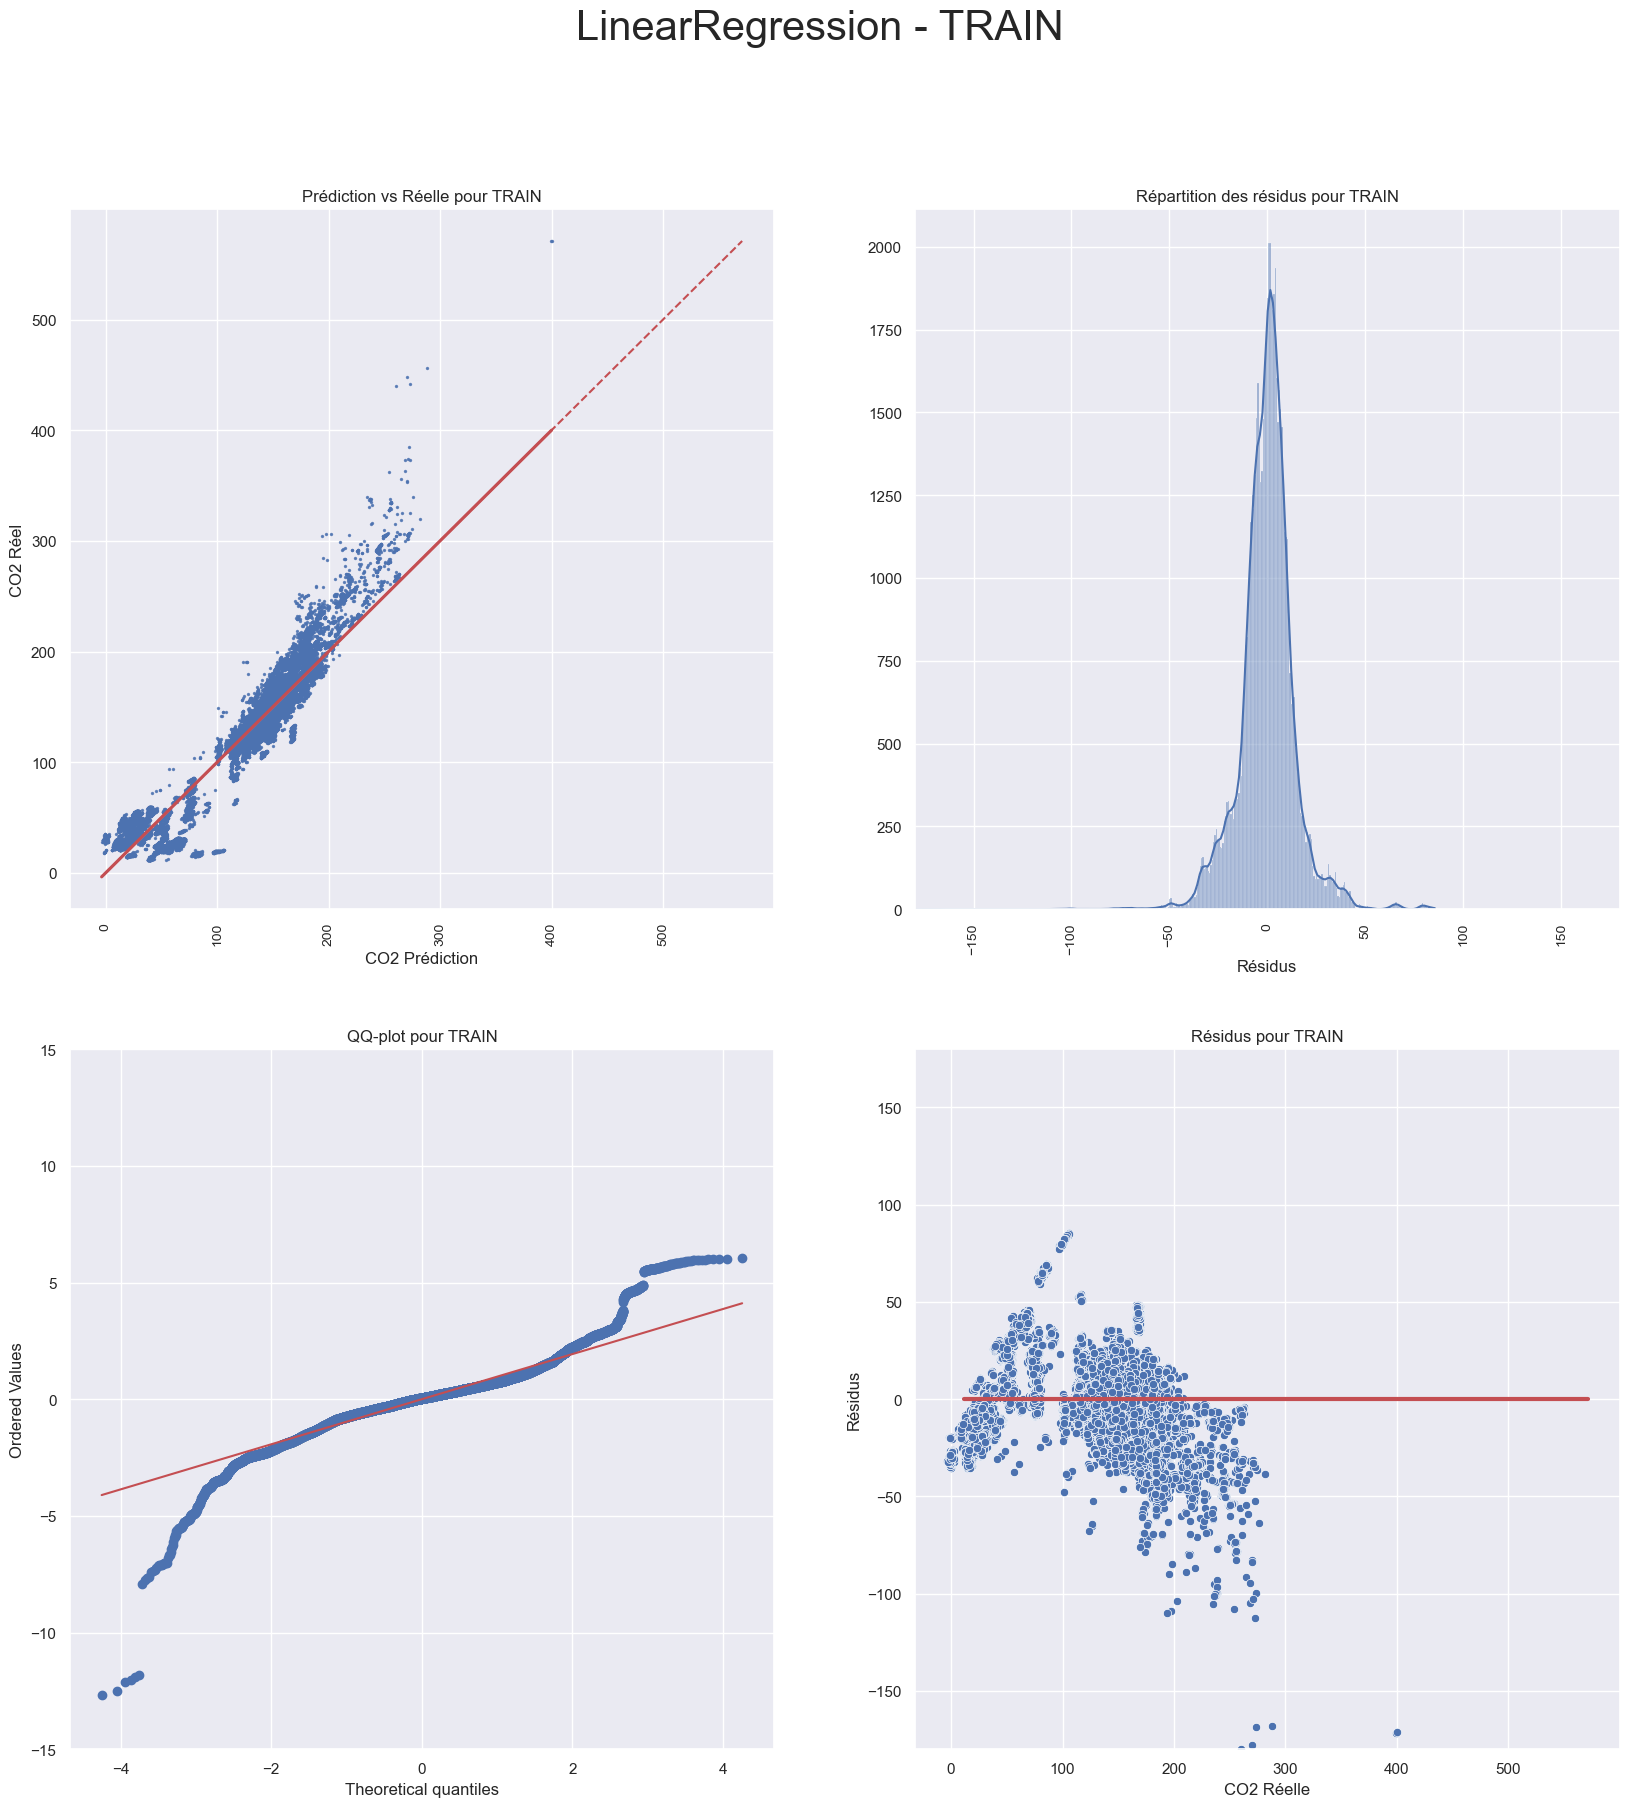

In [77]:
sns.set()
# TRAIN
plt.figure(figsize=(20, 20))
plt.suptitle("LinearRegression - TRAIN", fontsize=30)
plt.subplot(2, 2, 1)
gfg = sns.regplot(data=df_train, x="Valeur Prédite", y="Valeur Réelle", fit_reg=True, line_kws=dict(color="r"), scatter_kws={'s':2})
ax = plt.plot((y_train.min(), y_train.max()), 
              (y_train.min(), y_train.max()), "--", c="r")
plt.xlabel("CO2 Prédiction")
plt.ylabel("CO2 Réel")
plt.title("Prédiction vs Réelle pour TRAIN")
plt.xticks(rotation=90, fontsize="small")

plt.subplot(2, 2, 2)
gfg =sns.histplot(data=df_train, x="Résidus", kde=True, line_kws=dict(color="r"))
plt.xlabel("Résidus")
plt.ylabel("")
plt.xlim(-res_max, res_max)
plt.title("Répartition des résidus pour TRAIN")
plt.xticks(rotation=90, fontsize="small")

residus_norm = (df_train["Résidus"] - df_train["Résidus"].mean()) / df_train["Résidus"].std()
plt.subplot(2, 2, 3)
s = stats.probplot(residus_norm, plot=plt)
plt.ylim(-15, 15)
plt.title("QQ-plot pour TRAIN")

plt.subplot(2, 2, 4)
sns.scatterplot(data=df_train, x="Valeur Prédite", y="Résidus", color="b")
plt.plot((y_train.min(), y_train.max()), (0, 0), lw=3, color="r")
plt.ylim(-res_max, res_max)
plt.xlabel("CO2 Réelle")
plt.ylabel("Résidus")
plt.title("Résidus pour TRAIN") 

plt.show()
plt.close()

## TEST

C:\Users\Kogitos\anaconda3\envs\DST-FEV-24-PROJECT\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

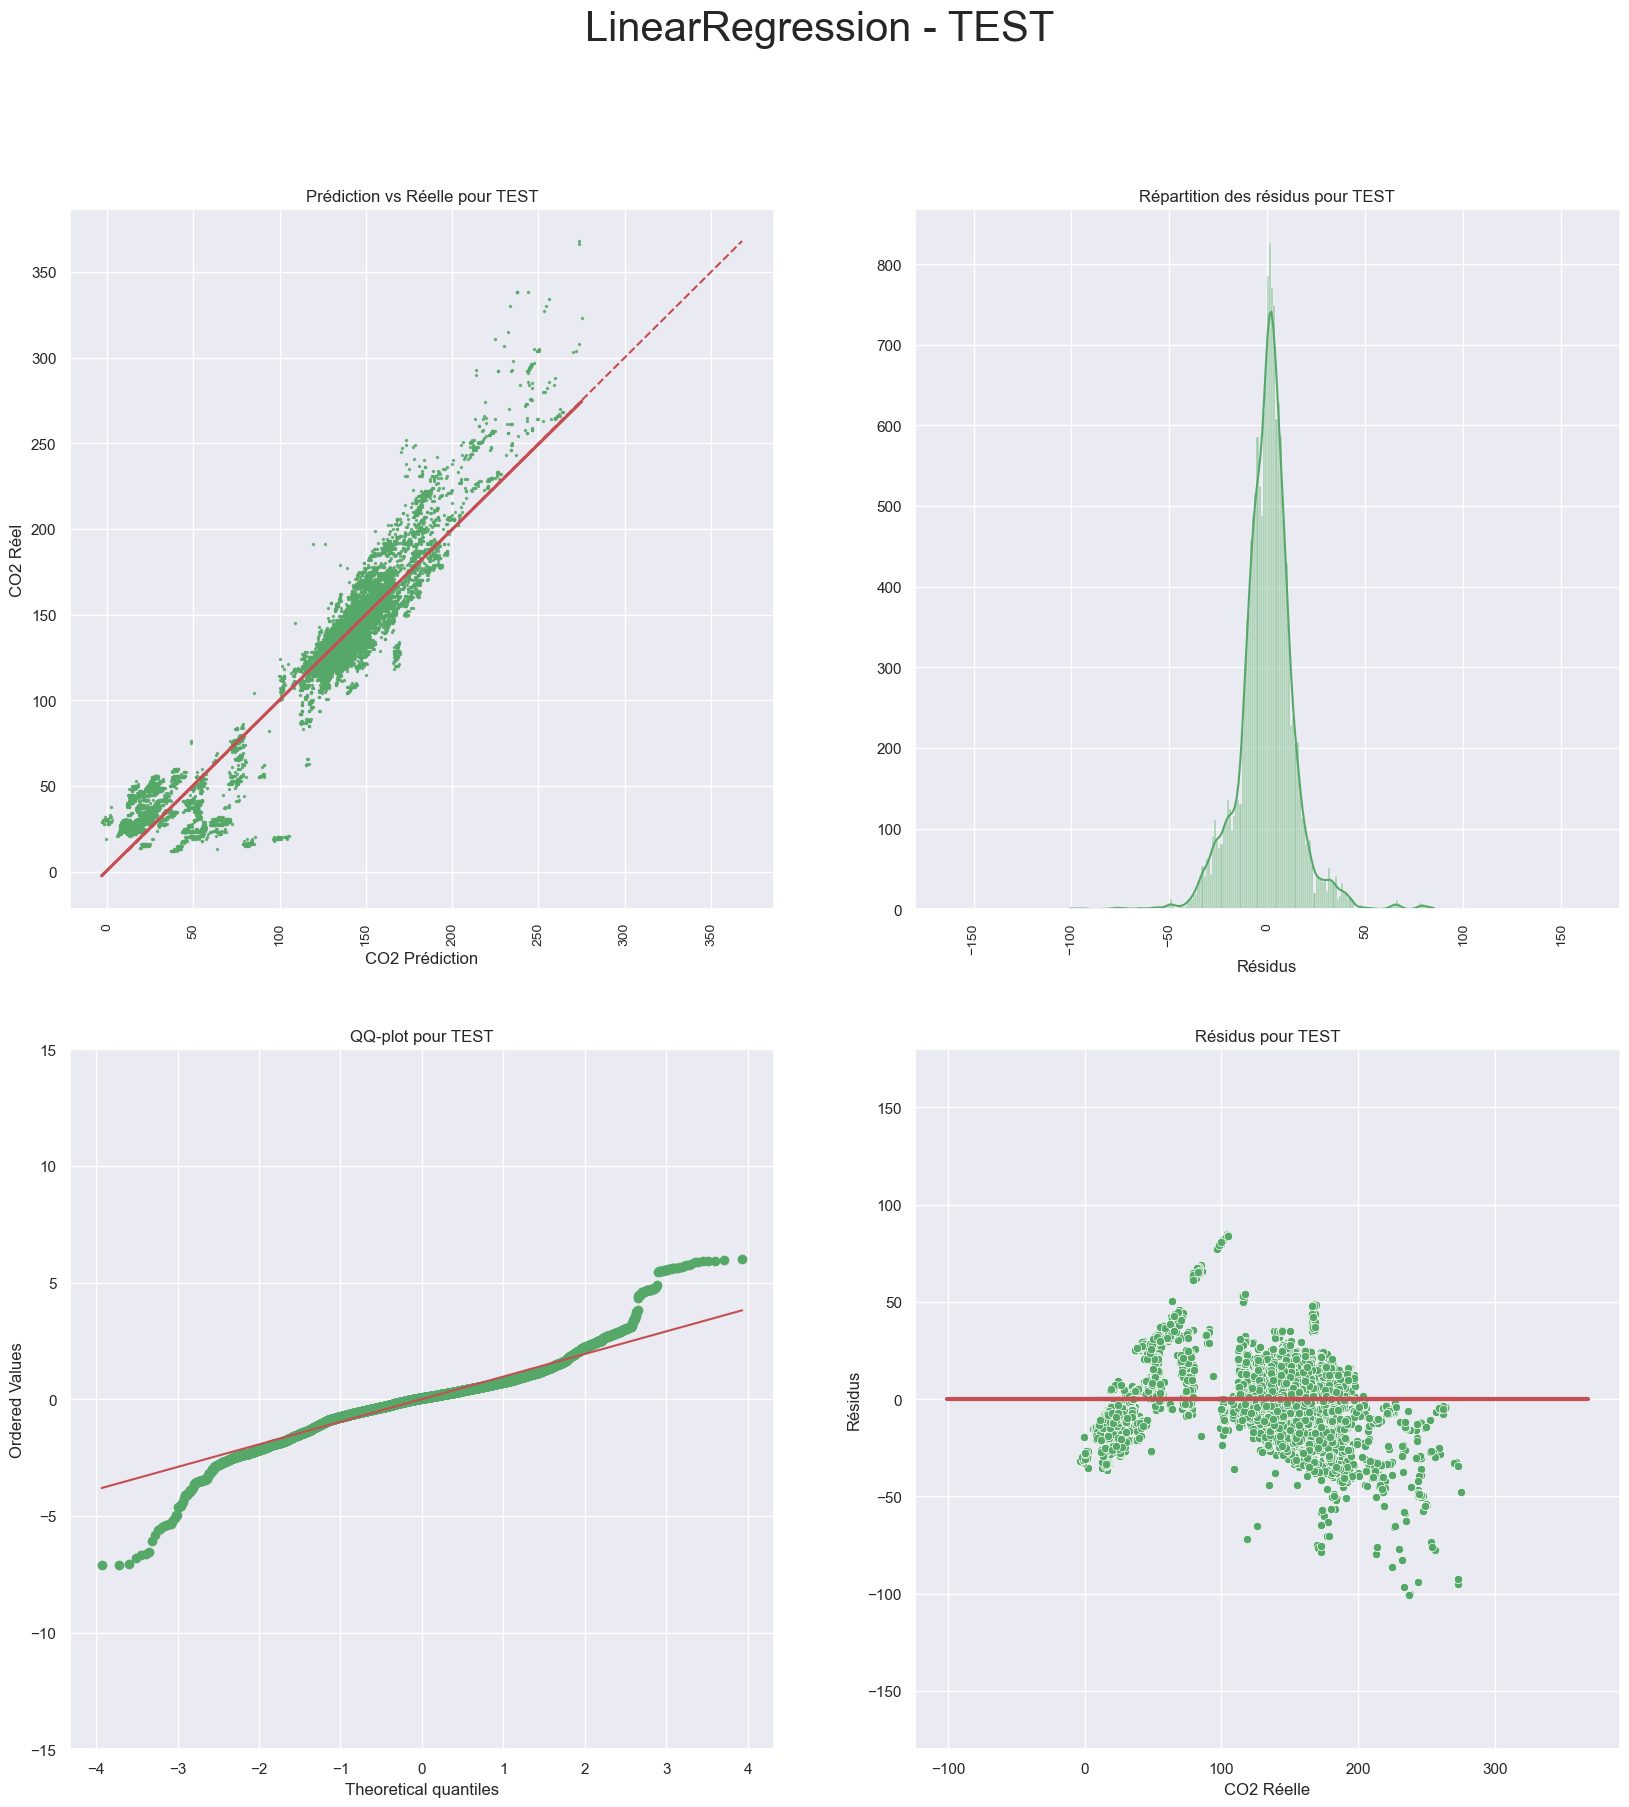

In [79]:
sns.set()
plt.clf()
# TEST

plt.figure(figsize=(20, 20))
plt.suptitle("LinearRegression - TEST", fontsize=30)
plt.subplot(2, 2, 1)
gfg = sns.regplot(data=df_test, x="Valeur Prédite", y="Valeur Réelle", color="g", fit_reg=True, line_kws=dict(color="r"), scatter_kws={'s':2})
ax = plt.plot((y_test.min(), y_test.max()), 
              (y_test.min(), y_test.max()), "--", c="r")
plt.xlabel("CO2 Prédiction")
plt.ylabel("CO2 Réel")
plt.title("Prédiction vs Réelle pour TEST")
plt.xticks(rotation=90, fontsize="small")

plt.subplot(2, 2, 2)
gfg =sns.histplot(data=df_test, x="Résidus", kde=True, color="g", line_kws=dict(color="g"))
plt.xlabel("Résidus")
plt.ylabel("")
plt.xlim(-res_max, res_max)
plt.title("Répartition des résidus pour TEST")
plt.xticks(rotation=90, fontsize="small")

residus_norm = (df_test["Résidus"] - df_test["Résidus"].mean()) / df_test["Résidus"].std()
ax = plt.subplot(2, 2, 3)
s = stats.probplot(residus_norm, plot=plt)
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_color('g')
plt.ylim(-15, 15)
plt.title("QQ-plot pour TEST")

plt.subplot(2, 2, 4)
sns.scatterplot(data=df_test, x="Valeur Prédite", y="Résidus", color="g")
plt.plot((df_test.min(), df_test.max()), (0, 0), lw=3, color="r")
plt.ylim(-res_max, res_max)
plt.xlabel("CO2 Réelle")
plt.ylabel("Résidus")
plt.title("Résidus pour TEST") 

plt.show()
plt.close()

# Importance des features

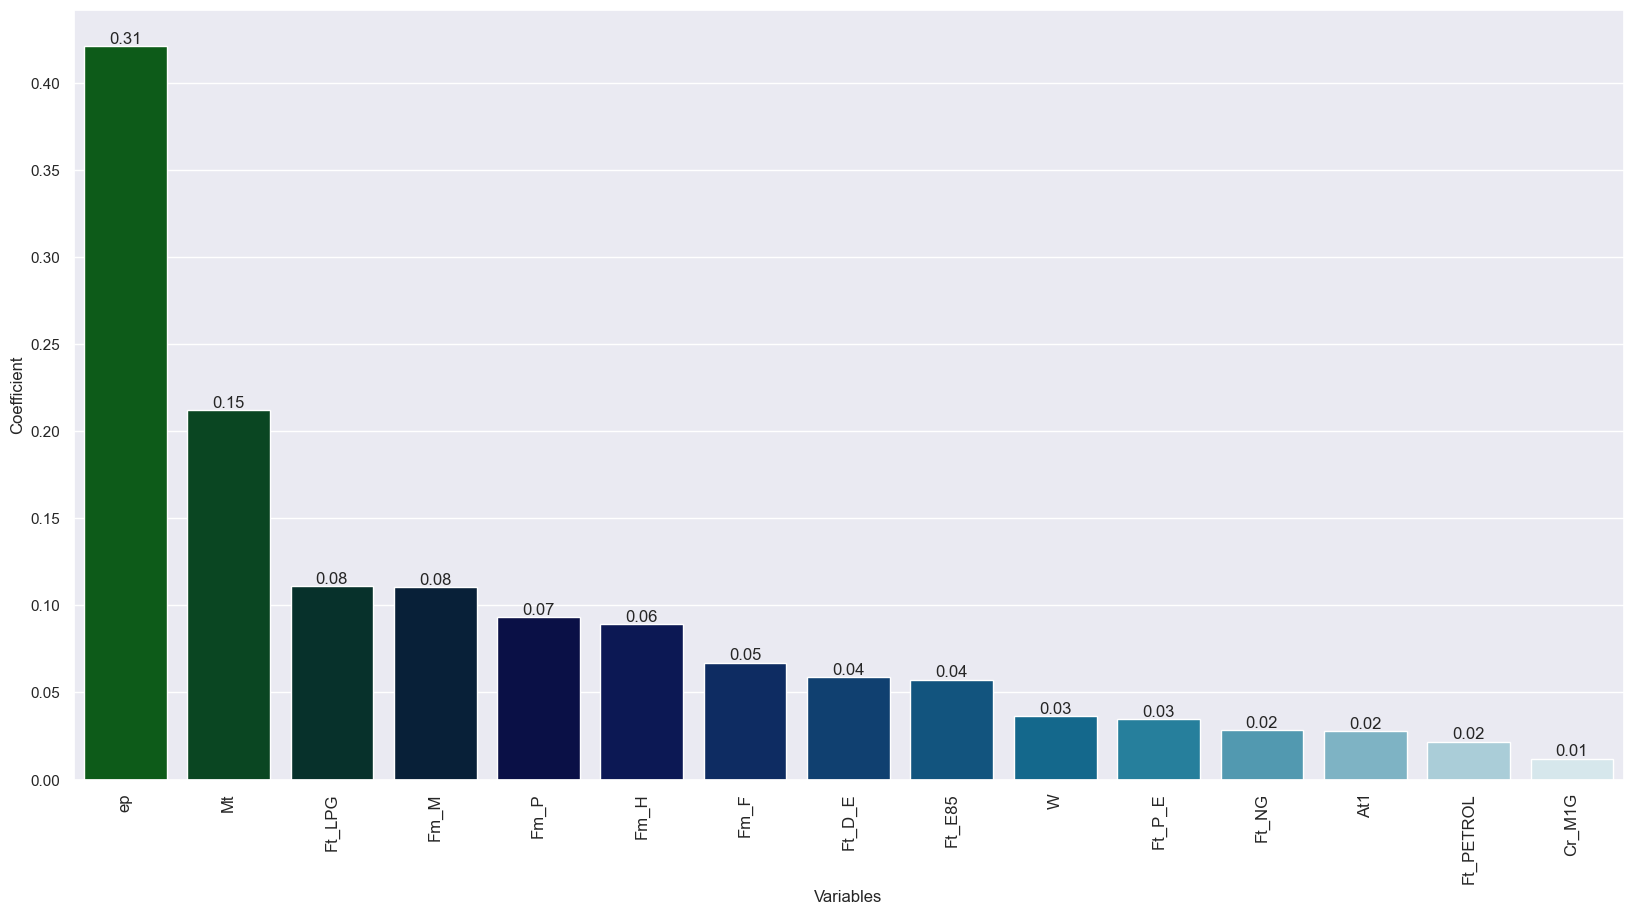

In [118]:
df_coefs = pd.DataFrame({
    "feature_names": feature_names, 
    "coefs": abs(coefs),
    "coefs_reel": coefs},
)

percent = round((df_coefs["coefs"] / df_coefs["coefs"].sum()), 2)
df_coefs["percent"] = percent

df_coefs["percent_reel"] = round((df_coefs["coefs_reel"] / abs(df_coefs["coefs_reel"]).sum()), 2)
df_coefs.sort_values(by="coefs", ascending=False, inplace=True)

sns.set()
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(data=df_coefs, x="feature_names", y="coefs", palette="ocean")
ax.bar_label(ax.containers[0], labels=df_coefs["percent"], fmt="{:.1f}")
plt.xlabel("Variables")
plt.ylabel("Coefficient")
plt.xticks(rotation=90, fontsize="12")
plt.show()
plt.close()

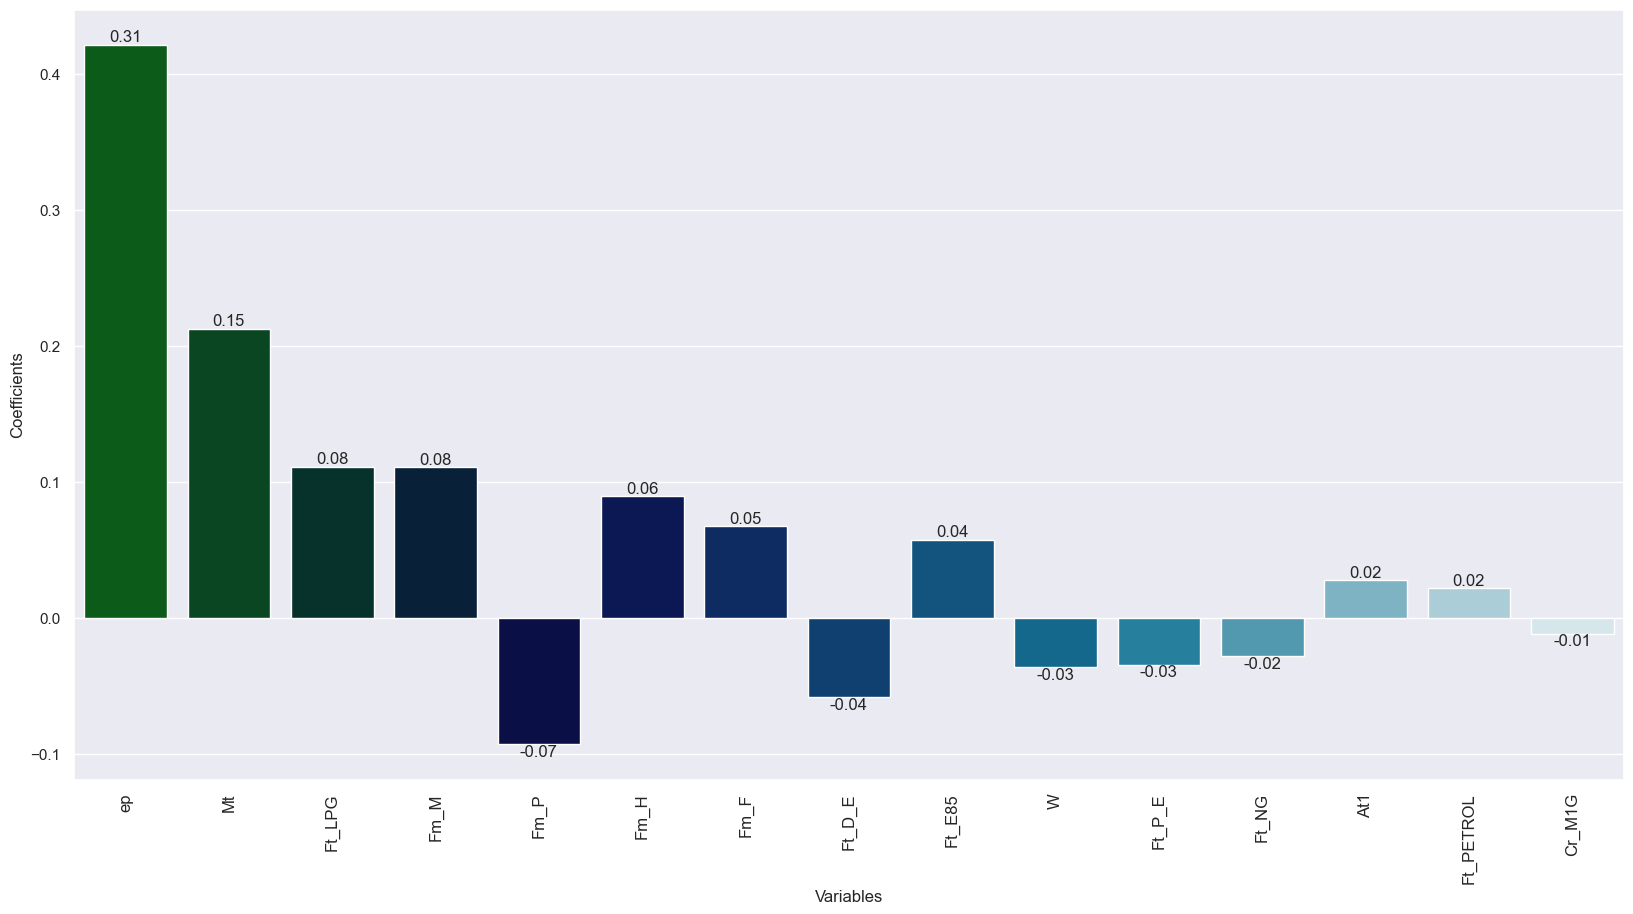

In [120]:
sns.set()
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(data=df_coefs, x="feature_names", y="coefs_reel", palette="ocean")
ax.bar_label(ax.containers[0], labels=df_coefs["percent_reel"], fmt="{:.1f}")
plt.xlabel("Variables")
plt.ylabel("Coefficients")
plt.xticks(rotation=90, fontsize="12")
plt.show()
plt.close()

In [84]:
import shap
explainer = shap.explainers.Linear(model, X_train)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


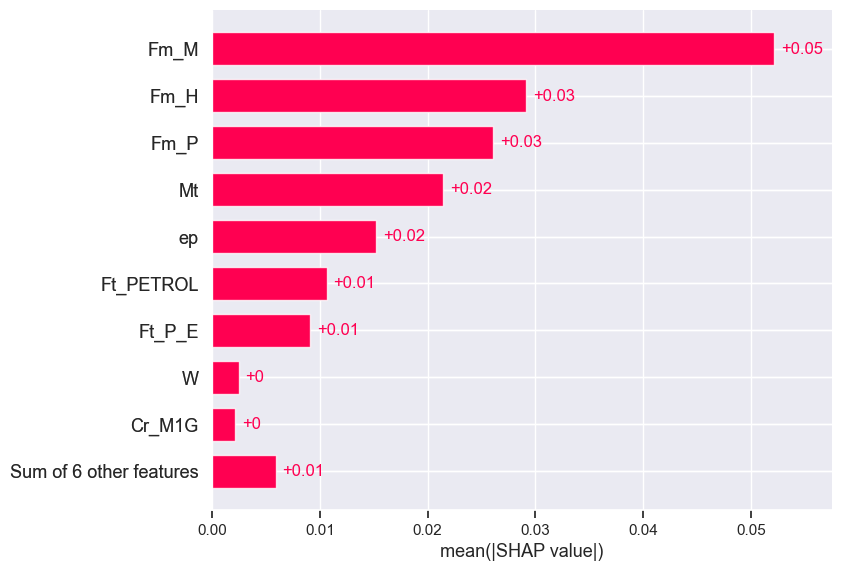

In [88]:
# Après discoussion avec Eliott, 
# Shap n'est pas adapté pour expliquer les modèles de régression simple
shap_values = explainer(X_train)
shap.plots.bar(shap_values)

# Ne pas utiliser